In [1]:
!pip install fcsparser==0.2.0
!pip install FlowUtils==0.7.1
!pip install scipy==1.4.1

DEPRECATION: Python 3.5 reached the end of its life on September 13th, 2020. Please upgrade your Python as Python 3.5 is no longer maintained. pip 21.0 will drop support for Python 3.5 in January 2021. pip 21.0 will remove support for this functionality.
DEPRECATION: Python 3.5 reached the end of its life on September 13th, 2020. Please upgrade your Python as Python 3.5 is no longer maintained. pip 21.0 will drop support for Python 3.5 in January 2021. pip 21.0 will remove support for this functionality.
DEPRECATION: Python 3.5 reached the end of its life on September 13th, 2020. Please upgrade your Python as Python 3.5 is no longer maintained. pip 21.0 will drop support for Python 3.5 in January 2021. pip 21.0 will remove support for this functionality.


In [2]:
import os
import sys
import pickle
import glob
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy
from scipy.signal import argrelextrema

import fcsparser 
import flowutils
from flowutils import transforms


sys.path.append('../common')
import data_io_utils
import paths
import constants
import utils

import A009_common

%reload_ext autoreload
%autoreload 2

In [3]:
data_dir = os.path.join(data_io_utils.S3_DATA_ROOT, 'chip_1', 'Post_Chip_1_GFP_FollowUp_ColonyPick_Flow')

In [4]:
data_io_utils.sync_s3_path_to_local(data_dir)

In [5]:
SSCA_LIM=[3.5, 4.0] 
FSCA_LIM=[3.7, 4.1]
SIGNAL_FLOOR = 2.36 # Based on negative control
WELLS_TO_EXCLUDE = (
    ['G11', 'H11', 'A12', 'B12', 'C12', 'D12', 'E12', 'F12', 'G12', 'H12'] # end of plate wells
    + ['D03', 'A08', 'B10', 'F08', 'E09', 'F07'] # These are wells whose manually taken image drastically differ from the Flow measurement.
)
            

def transform_data(data):
    tdata = np.log10(np.array(data))
    tdata[tdata == -np.inf] = 0
    tdata[np.isnan(tdata)] = 0
    
    tdata = pd.DataFrame(tdata, columns=data.columns)
    return tdata

def gate_on_SSC_and_FSC(data, SSCA_lim=SSCA_LIM, FSCA_lim=FSCA_LIM):
    mask = np.logical_and(
        np.logical_and(data['SSC-A'] > SSCA_lim[0], data['SSC-A'] < SSCA_lim[1]),
        np.logical_and(data['FSC-A'] > FSCA_lim[0], data['SSC-A'] < FSCA_lim[1]),
    )
    
    return data[mask]

def detect_best_peak(x):
    """
    Detects the mode of the peak representing
    the major population of cells.
    """
    grid = np.linspace(1,7,200)
    h = np.histogram(x, bins=grid)
    hData = h[0]
    peaks = argrelextrema(hData, np.greater)[0]

    peak_idx = np.argmax(hData[peaks])

    data_mode = grid[peaks[peak_idx]]
    return data_mode


def analyze_well_fcs(fcs_file):
    meta, data = fcsparser.parse(fcs_file, reformat_meta=True)
    
    tdata = transform_data(data)
    tdata_gated = gate_on_SSC_and_FSC(tdata)
    
    res = {}
    res['total_events'] = data.shape[0]
    res['frac_retained_post_gate'] = tdata_gated.shape[0]/data.shape[0]
    
    res['B525'] = np.maximum(detect_best_peak(tdata['B525-FITC-A']) - SIGNAL_FLOOR, 0)
    res['V525'] = np.maximum(detect_best_peak(tdata['V525-KrO-A']) - SIGNAL_FLOOR, 0)
    
    return res

def analyze_plate(rep):
    fcs_files = glob.glob(os.path.join(data_dir, '0%s*.fcs'%str(rep)))
    sorted(fcs_files)
    print(len(fcs_files))

    res = {}
    for fcs in fcs_files:
        well = fcs.replace('.fcs', '').split('-')[-1]

        if len(well) == 2:
            well = well[0] + '0' + well[1]

        res[well] = analyze_well_fcs(fcs)

    res_df = pd.DataFrame(res).T
    res_df.columns = [c + '_rep' + str(rep) for c in res_df.columns]
    
    res_df['well'] = res_df.index
    res_df.reset_index(drop=True, inplace=True)
        
    return res_df

In [6]:
rep1_df = analyze_plate(1)
rep2_df = analyze_plate(2)

96


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log10
  # This is added back by InteractiveShellApp.init_path()


96


In [7]:
df = pd.merge(rep1_df, rep2_df, on='well')
df.head()

,B525_rep1,V525_rep1,frac_retained_post_gate_rep1,total_events_rep1,well,B525_rep2,V525_rep2,frac_retained_post_gate_rep2,total_events_rep2
0,0.991759,2.137487,0.681899,103882.0,A01,1.112362,2.137487,0.525539,122676.0
1,2.197789,1.655075,0.760318,104697.0,A02,2.227940,1.655075,0.727116,108405.0
2,1.896281,1.685226,0.737155,110392.0,A03,1.986734,1.745528,0.693249,112554.0
3,2.288241,1.805829,0.748580,105787.0,A04,2.227940,1.835980,0.685251,112944.0
4,2.288241,1.383719,0.771342,103915.0,A05,2.288241,1.353568,0.633971,120657.0


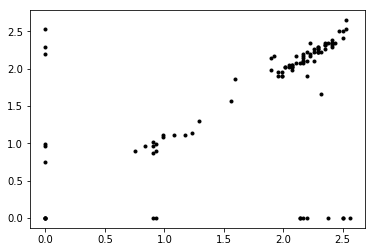

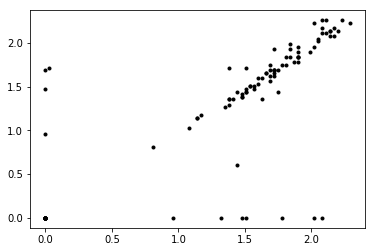

In [8]:
plt.plot(df['B525_rep1'], df['B525_rep2'], '.k')
plt.show()

plt.plot(df['V525_rep1'], df['V525_rep2'], '.k')
plt.show()

## Clearly quite reproducible, except for a few  exceptions

This is because during the flow, there were some drop out wells that didnt have a normal SSC and FSC pattern. For these wells the cytometer sorted what it could but it wasn't as many cells in the end.


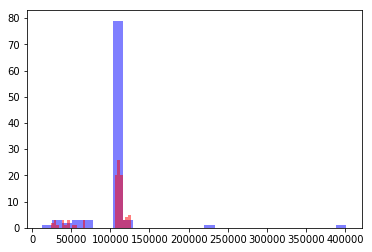

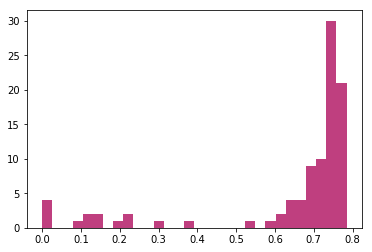

In [9]:
plt.hist(df['total_events_rep1'],bins=30, color='b', alpha=0.5)
plt.hist(df['total_events_rep2'],bins=30, color='r', alpha=0.5)
plt.show()

plt.hist(df['frac_retained_post_gate_rep1'],bins=30, color='b', alpha=0.5)
plt.hist(df['frac_retained_post_gate_rep1'],bins=30, color='r', alpha=0.5)
plt.show()

mask = np.logical_or(df['frac_retained_post_gate_rep1'] < 0.6, 
                     df['frac_retained_post_gate_rep2'] < 0.6)

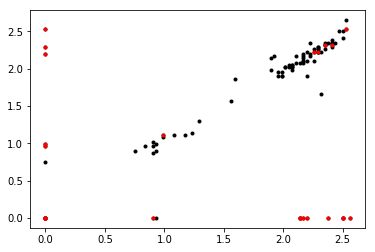

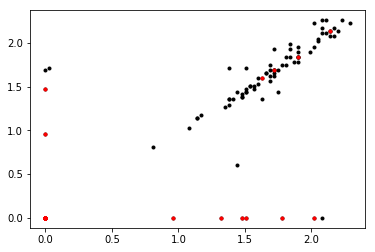

In [10]:
plt.plot(df['B525_rep1'], df['B525_rep2'], '.k')
plt.plot(df['B525_rep1'][mask], df['B525_rep2'][mask], '.r')
plt.show()

plt.plot(df['V525_rep1'], df['V525_rep2'], '.k')
plt.plot(df['V525_rep1'][mask], df['V525_rep2'][mask], '.r')
plt.show()

## Combine into a single measurement and calculate uncertainty.

For wells with two good measurements we'll calculate uncertainty using the usual standard devation. For wells with one good and one bad measurement, we'll make the estimated mean the greater of the two and and the standard deviation be a robust esimate of the global standard deviation.

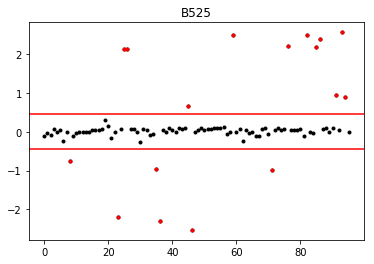

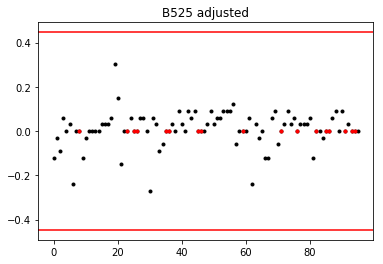

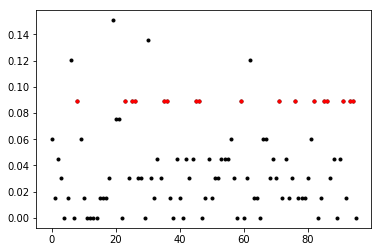

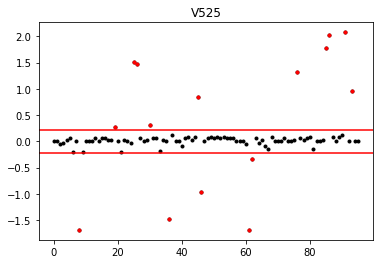

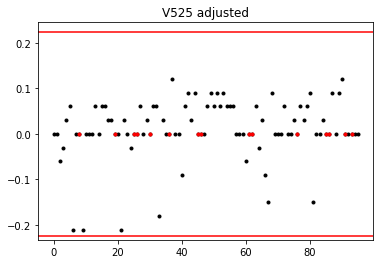

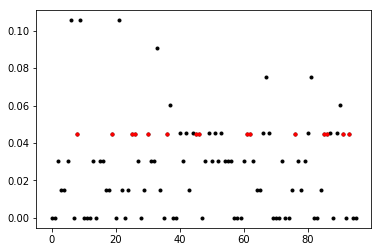

In [11]:
OUTLIER_N_MAD = 5 # number of MADs away before being called an outlier

global_std = {}
for channel in ['B525', 'V525']:
    ch_rep1 = np.array(df[channel + '_rep1'])
    ch_rep2 = np.array(df[channel + '_rep2'])
    
    global_std[channel] = scipy.stats.median_absolute_deviation(ch_rep1 - ch_rep2)
    
    large_dev = np.abs(ch_rep1-ch_rep2) > OUTLIER_N_MAD*global_std[channel]
    
    ch_rep1_adj = copy.deepcopy(ch_rep1)
    ch_rep2_adj = copy.deepcopy(ch_rep2)
    
    tmp = np.maximum(ch_rep1_adj, ch_rep2_adj)
    ch_rep1_adj[large_dev] = tmp[large_dev]
    ch_rep2_adj[large_dev] = tmp[large_dev]
    
    
    plt.plot(ch_rep1 - ch_rep2, '.k')
    plt.plot(np.arange(len(ch_rep1))[large_dev], (ch_rep1 - ch_rep2)[large_dev], '.r')
    plt.axhline(OUTLIER_N_MAD*global_std[channel], color='r')
    plt.axhline(-OUTLIER_N_MAD*global_std[channel], color='r')
    plt.title(channel)
    plt.show()
    
    plt.plot(ch_rep1_adj - ch_rep2_adj, '.k')
    plt.plot(np.arange(len(ch_rep1))[large_dev], (ch_rep1_adj - ch_rep2_adj)[large_dev], '.r')
    plt.axhline(OUTLIER_N_MAD*global_std[channel], color='r')
    plt.axhline(-OUTLIER_N_MAD*global_std[channel], color='r')
    plt.title(channel + ' adjusted')
    plt.show()
    
    # Averaged
    m_adj = np.vstack([ch_rep1_adj, ch_rep2_adj])
    mu = np.mean(m_adj, axis=0)
    std = np.std(m_adj, axis=0)
    std[large_dev] = global_std[channel]
    
    df[channel + '_mean'] = mu
    df[channel + '_std'] = std
    
    plt.plot(np.arange(len(df[channel + '_std'])), df[channel + '_std'], '.k')
    plt.plot(np.arange(len(df[channel + '_std']))[large_dev], df[channel + '_std'][large_dev], '.r')
    plt.show()

Finally combine 525 signal by summing B525 and V525

In [12]:
df['525_mean'] = (df['B525_mean'] + df['V525_mean'])/2
df['525_std'] = np.sqrt(df['B525_std']**2 + df['V525_std']**2) # variances add, and then sqrt.

display(df.head())

,B525_rep1,V525_rep1,frac_retained_post_gate_rep1,total_events_rep1,well,B525_rep2,V525_rep2,frac_retained_post_gate_rep2,total_events_rep2,B525_mean,B525_std,V525_mean,V525_std,525_mean,525_std
0,0.991759,2.137487,0.681899,103882.0,A01,1.112362,2.137487,0.525539,122676.0,1.052060,0.060302,2.137487,0.000000,1.594774,0.060302
1,2.197789,1.655075,0.760318,104697.0,A02,2.227940,1.655075,0.727116,108405.0,2.212864,0.015075,1.655075,0.000000,1.933970,0.015075
2,1.896281,1.685226,0.737155,110392.0,A03,1.986734,1.745528,0.693249,112554.0,1.941508,0.045226,1.715377,0.030151,1.828442,0.054355
3,2.288241,1.805829,0.748580,105787.0,A04,2.227940,1.835980,0.685251,112944.0,2.258090,0.030151,1.820905,0.015075,2.039497,0.033710
4,2.288241,1.383719,0.771342,103915.0,A05,2.288241,1.353568,0.633971,120657.0,2.288241,0.000000,1.368643,0.015075,1.828442,0.015075


## Visualize in plate format

In [13]:
np.array(df['well']).reshape(8, 12) # correct ordering

array([['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09',
        'A10', 'A11', 'A12'],
       ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09',
        'B10', 'B11', 'B12'],
       ['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09',
        'C10', 'C11', 'C12'],
       ['D01', 'D02', 'D03', 'D04', 'D05', 'D06', 'D07', 'D08', 'D09',
        'D10', 'D11', 'D12'],
       ['E01', 'E02', 'E03', 'E04', 'E05', 'E06', 'E07', 'E08', 'E09',
        'E10', 'E11', 'E12'],
       ['F01', 'F02', 'F03', 'F04', 'F05', 'F06', 'F07', 'F08', 'F09',
        'F10', 'F11', 'F12'],
       ['G01', 'G02', 'G03', 'G04', 'G05', 'G06', 'G07', 'G08', 'G09',
        'G10', 'G11', 'G12'],
       ['H01', 'H02', 'H03', 'H04', 'H05', 'H06', 'H07', 'H08', 'H09',
        'H10', 'H11', 'H12']], dtype=object)

In [14]:
B525 = np.array(df['B525_mean']).reshape(8,12)
V525 = np.array(df['V525_mean']).reshape(8,12)

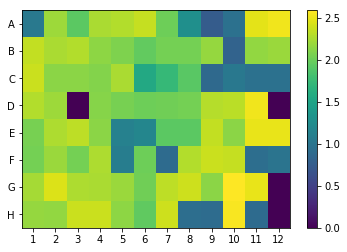

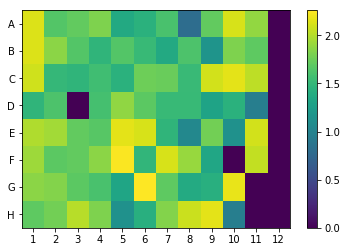

In [15]:
def imshow_plate_fluor(m):
    plt.imshow(m, aspect='auto')
    plt.yticks(np.arange(0,8))
    plt.gca().set_yticklabels(list('ABCDEFGH'))
    plt.xticks(np.arange(0,12))
    plt.gca().set_xticklabels(np.arange(1,13))
    plt.clim([0, np.max(m)])
    plt.colorbar()
    plt.show()
    
imshow_plate_fluor(B525)
imshow_plate_fluor(V525)

## Export

In [16]:
mask = df['well'].apply(lambda x: str(x) not in WELLS_TO_EXCLUDE)
df_sub = df[mask]
print(df_sub.shape)

(80, 15)


In [17]:
df_sub.to_csv('A009e_post_chip_1_gfp_colony_pick_flow.csv', index=False)
print(df_sub.shape)

(80, 15)
